In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import sys
import os

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *

import matplotlib.pyplot as plt
%matplotlib inline

from joblib import Parallel, delayed
import time

In [3]:
labels = ['BackG', '5N', '7n', '7N', '12N', 'Pn', 'VLL', 
          '6N', 'Amb', 'R', 'Tz', 'RtTg', 'LRt', 'LC', 'AP', 'sp5']

n_labels = len(labels)

labels_index = dict((j, i) for i, j in enumerate(labels))

labels_from_surround = dict( (l+'_surround', l) for l in labels[1:])

labels_surroundIncluded_list = labels[1:] + [l+'_surround' for l in labels[1:]]
labels_surroundIncluded = set(labels_surroundIncluded_list)

labels_surroundIncluded_index = dict((j, i) for i, j in enumerate(labels_surroundIncluded_list))

# colors = np.random.randint(0, 255, (len(labels_index), 3))
colors = np.loadtxt(os.environ['REPO_DIR'] + '/visualization/100colors.txt')
colors[labels_index['BackG']] = 1.

In [4]:
volume_dir = '/oasis/projects/nsf/csd395/yuncong/CSHL_volumes/'

In [5]:
volume1 = bp.unpack_ndarray_file(os.path.join(volume_dir, 'volume_MD589_annotation.bp'))
atlas_ydim, atlas_xdim, atlas_zdim = volume1.shape
print atlas_xdim, atlas_ydim, atlas_zdim

810 405 534


In [6]:
def parallel_where(l):
    w = np.where(volume1 == l)
    return [w[1], w[0], w[2]]

t = time.time()

atlas_nzs = Parallel(n_jobs=16)(delayed(parallel_where)(l) for l in range(1, n_labels))

print time.time() - t, 'seconds'

atlas_xmin, atlas_ymin, atlas_zmin = np.min([np.min(atlas_nzs[l-1], axis=1) for l in range(1, n_labels)], axis=0)
atlas_xmax, atlas_ymax, atlas_zmax = np.max([np.max(atlas_nzs[l-1], axis=1) for l in range(1, n_labels)], axis=0)
print atlas_xmin, atlas_xmax, atlas_ymin, atlas_ymax, atlas_zmin, atlas_zmax

atlas_centroid = np.array([.5*atlas_xmin+.5*atlas_xmax, .5*atlas_ymin+.5*atlas_ymax, .5*atlas_zmin+.5*atlas_zmax])
print atlas_centroid

atlas_cx, atlas_cy, atlas_cz = atlas_centroid

2.20446491241 seconds
0 809 0 404 0 533
[ 404.5  202.   266.5]


In [7]:
downsample_factor = 16

section_thickness = 20 # in um
xy_pixel_distance_lossless = 0.46
xy_pixel_distance_tb = xy_pixel_distance_lossless * 32 # in um, thumbnail
# factor = section_thickness/xy_pixel_distance_lossless

xy_pixel_distance_downsampled = xy_pixel_distance_lossless * downsample_factor
z_xy_ratio_downsampled = section_thickness / xy_pixel_distance_downsampled

In [8]:
atlasAlignOptLogs_dir = '/oasis/projects/nsf/csd395/yuncong/CSHL_atlasAlignOptLogs'
if not os.path.exists(atlasAlignOptLogs_dir):
    os.makedirs(atlasAlignOptLogs_dir)

In [9]:
atlasAlignParams_dir = '/oasis/projects/nsf/csd395/yuncong/CSHL_atlasAlignParams'
if not os.path.exists(atlasAlignParams_dir):
    os.makedirs(atlasAlignParams_dir)

In [10]:
annotationsViz_rootdir = '/oasis/projects/nsf/csd395/yuncong/CSHL_annotaionsPojectedViz'

In [11]:
stack = 'MD594'

In [12]:
with open(atlasAlignParams_dir + '/%(stack)s_3dAlignParams.txt' % {'stack': stack}, 'r') as f:
    lines = f.readlines()
T_final = map(float, lines[1].strip().split())

In [13]:
ds = []
for l in range(1, n_labels):
    ds.append(np.array(atlas_nzs[l-1]) - atlas_centroid[:, np.newaxis])

In [14]:
section_bs_begin, section_bs_end = section_range_lookup[stack]
print section_bs_begin, section_bs_end

(volume_xmin, volume_xmax, volume_ymin, volume_ymax, volume_zmin, volume_zmax) = \
np.loadtxt(os.path.join(volume_dir, 'volume_%(stack)s_scoreMap_limits.txt' % {'stack': stack}), dtype=np.int)

map_z_to_section = {}
for s in range(section_bs_begin, section_bs_end+1):
    for z in range(int(z_xy_ratio_downsampled*s) - volume_zmin, int(z_xy_ratio_downsampled*(s+1)) - volume_zmin + 1):
        map_z_to_section[z] = s

global volume2_allLabels
volume2_allLabels = []

for l in labels[1:]:

    print l

    volume2 = bp.unpack_ndarray_file(os.path.join(volume_dir, 'volume_%(stack)s_scoreMap_%(label)s.bp' % \
                                                  {'stack': stack, 'label': l}))

    volume2_cropped = volume2[volume_ymin:volume_ymax+1, volume_xmin:volume_xmax+1]
    # copy is important, because then you can delete the large array

    volume2_allLabels.append(volume2_cropped.copy())

    del volume2, volume2_cropped

test_ydim, test_xdim, test_zdim = volume2_allLabels[0].shape
test_centroid = (.5*test_xdim, .5*test_ydim, .5*test_ydim)
test_cx, test_cy, test_cz = test_centroid

print test_xdim, test_ydim, test_zdim
print test_centroid

93 364
5N
7n
7N
12N
Pn
VLL
6N
Amb
R
Tz
RtTg
LRt
LC
AP
sp5
833 473 443
(416.5, 236.5, 236.5)


In [40]:
d2Sdxyz2 = []

for l in range(1, n_labels):
    
    print labels[l]
    
    t = time.time()
    
    gxx = load_hdf(volume_dir + '/volume_%(stack)s_scoreMap_%(lab)s_gxx.hdf' % {'stack': stack, 'lab': labels[l]}).astype(np.float16)
    gxy = load_hdf(volume_dir + '/volume_%(stack)s_scoreMap_%(lab)s_gxy.hdf' % {'stack': stack, 'lab': labels[l]}).astype(np.float16)
    gxz = load_hdf(volume_dir + '/volume_%(stack)s_scoreMap_%(lab)s_gxz.hdf' % {'stack': stack, 'lab': labels[l]}).astype(np.float16)
    gyx = load_hdf(volume_dir + '/volume_%(stack)s_scoreMap_%(lab)s_gyx.hdf' % {'stack': stack, 'lab': labels[l]}).astype(np.float16)
    gyy = load_hdf(volume_dir + '/volume_%(stack)s_scoreMap_%(lab)s_gyy.hdf' % {'stack': stack, 'lab': labels[l]}).astype(np.float16)
    gyz = load_hdf(volume_dir + '/volume_%(stack)s_scoreMap_%(lab)s_gyz.hdf' % {'stack': stack, 'lab': labels[l]}).astype(np.float16)
    gzx = load_hdf(volume_dir + '/volume_%(stack)s_scoreMap_%(lab)s_gzx.hdf' % {'stack': stack, 'lab': labels[l]}).astype(np.float16)
    gzy = load_hdf(volume_dir + '/volume_%(stack)s_scoreMap_%(lab)s_gzy.hdf' % {'stack': stack, 'lab': labels[l]}).astype(np.float16)
    gzz = load_hdf(volume_dir + '/volume_%(stack)s_scoreMap_%(lab)s_gzz.hdf' % {'stack': stack, 'lab': labels[l]}).astype(np.float16)
    
    print time.time() - t
    
    d2Sdxyz2.append([gxx, gxy, gxz, gyx, gyy, gyz, gzx, gzy, gzz])

5N
49.2545080185
7n
24.7514629364
7N
42.891974926
12N
27.2598628998
Pn
48.5611140728
VLL
49.3607850075
6N
37.0516579151
Amb
35.4038779736
R
47.9618051052
Tz
36.8326151371
RtTg
66.1060168743
LRt
49.6135981083
LC
52.8415188789
AP
35.5167138577
sp5
41.8120119572


In [ ]:
d2Sdxyz2[l-1]

In [79]:
def compute_score_hessian(T):
    
    Tm = np.reshape(T, (3,4))
    tx, ty, tz = Tm[:, 3]
    A = Tm[:, :3]

    d2MdT2 = np.zeros((12, 12))
    
    for l in range(1, n_labels):

        xs_prime, ys_prime, zs_prime = (np.dot(A, ds[l-1]) + \
                                        np.asarray([tx + test_cx, 
                                                    ty + test_cy, 
                                                    tz + test_cz])[:,np.newaxis]).astype(np.int)

        valid = (xs_prime >= 0) & (ys_prime >= 0) & (zs_prime >= 0) & \
            (xs_prime < test_xdim) & (ys_prime < test_ydim) & (zs_prime < test_zdim)

        if np.count_nonzero(valid) > 0:

            xs_prime_valid = xs_prime[valid]
            ys_prime_valid = ys_prime[valid]
            zs_prime_valid = zs_prime[valid]
            
            dxs, dys, dzs = ds[l-1][:, valid]

            Sxx_full, Sxy_full, Sxz_full, Syx_full, Syy_full, Syz_full, Szx_full, Szy_full, Szz_full = d2Sdxyz2[l-1]
            Sxx = Sxx_full[ys_prime_valid, xs_prime_valid, zs_prime_valid]
            Sxy = Sxy_full[ys_prime_valid, xs_prime_valid, zs_prime_valid]
            Sxz = Sxz_full[ys_prime_valid, xs_prime_valid, zs_prime_valid]
            Syx = Syx_full[ys_prime_valid, xs_prime_valid, zs_prime_valid]
            Syy = Syy_full[ys_prime_valid, xs_prime_valid, zs_prime_valid]
            Syz = Syz_full[ys_prime_valid, xs_prime_valid, zs_prime_valid]
            Szx = Szx_full[ys_prime_valid, xs_prime_valid, zs_prime_valid]
            Szy = Szy_full[ys_prime_valid, xs_prime_valid, zs_prime_valid]
            Szz = Szz_full[ys_prime_valid, xs_prime_valid, zs_prime_valid]

            rx = np.c_[Sxx*dxs, Sxx*dys, Sxx*dzs, Sxx, Sxy*dxs, Sxy*dys, Sxy*dzs, Sxy, Sxz*dxs, Sxz*dys, Sxz*dzs, Sxz]
            ry = np.c_[Syx*dxs, Syx*dys, Syx*dzs, Syx, Syy*dxs, Syy*dys, Syy*dzs, Syy, Syz*dxs, Syz*dys, Syz*dzs, Syz]
            rz = np.c_[Szx*dxs, Szx*dys, Szx*dzs, Szx, Szy*dxs, Szy*dys, Szy*dzs, Szy, Szz*dxs, Szz*dys, Szz*dzs, Szz]
            r1 = (rx*dxs[:,None]).sum(axis=0)
            r2 = (rx*dys[:,None]).sum(axis=0)
            r3 = (rx*dzs[:,None]).sum(axis=0)
            r4 = rx.sum(axis=0)
            r5 = (ry*dxs[:,None]).sum(axis=0)
            r6 = (ry*dys[:,None]).sum(axis=0)
            r7 = (ry*dzs[:,None]).sum(axis=0)
            r8 = ry.sum(axis=0)
            r9 = (rz*dxs[:,None]).sum(axis=0)
            r10 = (rz*dys[:,None]).sum(axis=0)
            r11 = (rz*dzs[:,None]).sum(axis=0)
            r12 = rz.sum(axis=0)
            
            d2MdT2_l = np.vstack([r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, r11, r12])
        
            del xs_prime_valid, ys_prime_valid, zs_prime_valid
            del dxs, dys, dzs
            del Sxx_full, Sxy_full, Sxz_full, Syx_full, Syy_full, Syz_full, Szx_full, Szy_full, Szz_full
            del Sxx, Sxy, Sxz, Syx, Syy, Syz, Szx, Szy, Szz
            del rx, ry, rz
            del r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, r11, r12
            
        
            d2MdT2 += d2MdT2_l
        
            del d2MdT2_l
        del xs_prime, ys_prime, zs_prime, valid
    
    return d2MdT2

mean curvature: -17090915.1771
mean curvature related to translations -206.960147858


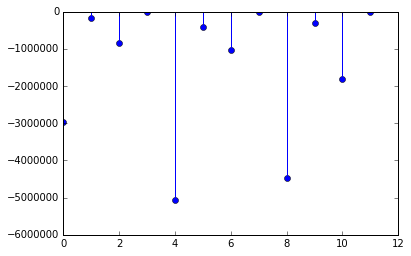

In [90]:
H = compute_score_hessian(T_final)
plt.stem(range(12), H.diagonal());
print 'mean curvature:', np.sum(H.diagonal())
print 'mean curvature related to translations:', np.sum(H.diagonal()[[3,7,11]])

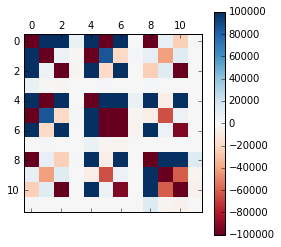

In [56]:
plt.matshow(H, cmap=plt.cm.RdBu, vmin=-1e5, vmax=1e5);
plt.colorbar();

In [92]:
# check hessian at neighborhoods of the optimum
for _ in range(10):
    Hr = compute_score_hessian(np.array(T_final) + [0,0,0,np.random.randint(-10,10),
                                                   0,0,0,np.random.randint(-10,10),
                                                   0,0,0,np.random.randint(-10,10)])
    print 'mean curvature:', np.sum(Hr.diagonal())
    print 'mean curvature related to translations:', np.sum(Hr.diagonal()[[3,7,11]])

mean curvature: -11185278.0965
mean curvature related to translations: -135.706656814
mean curvature: -6857306.63935
mean curvature related to translations: -92.6542387009
mean curvature: -16831300.6413
mean curvature related to translations: -201.508896232
mean curvature: -7253946.35548
mean curvature related to translations: -97.7462262511
mean curvature: -9101965.79851
mean curvature related to translations: -109.957354486
mean curvature: -4572370.69073
mean curvature related to translations: -67.3117328286
mean curvature: -9407685.10045
mean curvature related to translations: -125.558754146
mean curvature: -7734177.82181
mean curvature related to translations: -101.155700922
mean curvature: -7756772.58399
mean curvature related to translations: -84.1475672126
mean curvature: -10984504.2703
mean curvature related to translations: -138.46647507
